# Al-Ge eutectic alloy X-ray tomography dataset

Collected at BNL, FXI 18-ID, December 2021  

Paul Chao; pchao [at] umich.edu  
Feb  15, 2022

Sucessful dataset (118337)  
note:Al-Ge-w-post-solidification-Room Temp
Tomography scan at room temp of Al-Ge after solidification

In [1]:
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tifffile
import os
import time
from PIL import Image

In [2]:
file_path = 'C:\\Users\\askiran\\Desktop\\Al-Ge\\Tomo\\fly_scan_id_118337.h5';
#file_path = os.path.join('D:', os.sep, 'Data_storage', os.sep, '2021_data', os.sep, 'BNL Dec 2021', os.sep, 'fly_scan_id_118334.h5')
file = h5py.File(file_path, 'r')

In [3]:
print(list(file.keys()))
print(file["img_tomo"].shape)
print('Pixel Size: ' + str(np.array(file.get("Pixel Size"))))
print('note: ' +str(np.array(file.get("note"))))

['Magnification', 'Pixel Size', 'X_eng', 'angle', 'img_bkg', 'img_bkg_avg', 'img_dark', 'img_dark_avg', 'img_tomo', 'note', 'r_ini', 'scan_id', 'scan_time', 'uid', 'x_ini', 'y_ini', 'z_ini']
(908, 2160, 2560)
Pixel Size: b'21.676039012196203nm'
note: b'Al-Ge-w-solid-tomo-rt'


### Look at raw data (can also use HDFView)

Tomography data consists of forward projection images over an angular range of usually 180 degrees


Text(0, 0.5, 'Stage Y')

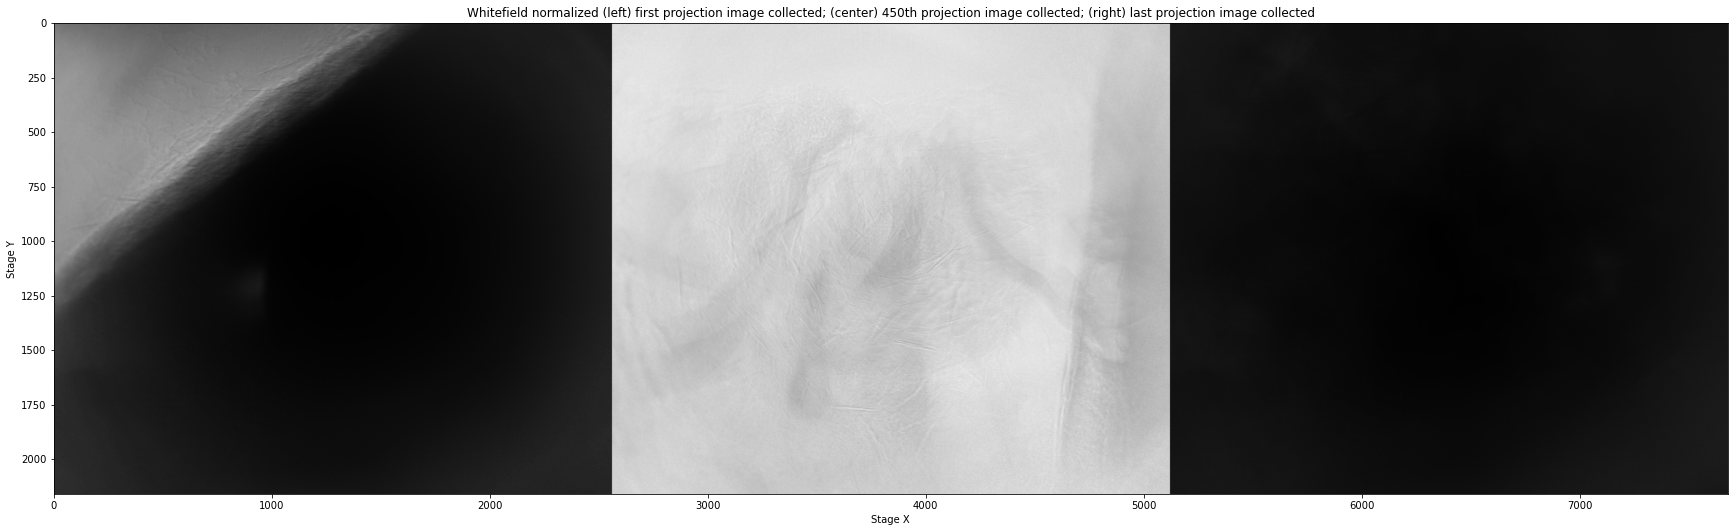

In [5]:
first_prj = file["img_tomo"][1,:,:]
mid_prj = file["img_tomo"][450,:,:]
last_prj = file["img_tomo"][-1,:,:]

white_prj = file["img_bkg_avg"]
dark_prj = file["img_dark_avg"]

# Montage
prj_images = np.concatenate((np.divide(first_prj,white_prj),np.divide(mid_prj,white_prj),np.divide(last_prj,white_prj)), axis=2)
plt.figure(figsize = (30,15))
plt.title('Whitefield normalized (left) first projection image collected; (center) 450th projection image collected; (right) last projection image collected')
plt.imshow(np.squeeze(prj_images), cmap = 'gray') #squeeze(), removes axis of size 1
plt.xlabel("Stage X")
plt.ylabel("Stage Y")

### Import data and process
1. Normalize with white and dark field
2. Remove stripes (in sinogram space) because of detector dead pixels
3. Take negative log because of Beer-Lambert law to back out the phase attenuation

In [14]:
chunk_size = 5
#num_chunks = 1 #512, 1024, 1536
chunk_start = 1500
chunk_end = chunk_start+chunk_size

time_start = time.time()

tomodata = file["img_tomo"][:,chunk_start:chunk_end,:]
#theta = np.linspace(0,2*np.pi,tomodata.shape[0])

white =  file["img_bkg"][:,chunk_start:chunk_end,:]
dark =  file["img_dark"][:,chunk_start:chunk_end,:]

time_start = time.time()

#print(' *** Normalizing')
proj = tomopy.normalize(tomodata, white, dark)

#print(' *** Remove Stripes')
proj = tomopy.prep.stripe.remove_all_stripe(proj)

# remove negative numbers
proj = tomopy.misc.corr.remove_neg(proj, val=1e-3)

#print(' *** - log')
proj = tomopy.minus_log(proj)

time_end  = time.time()
print(' *** prep done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')

 *** prep done in 0.08 minutes


### Show the sinogram
The sinogram is the projections under different angles organized in 2D

(908, 5, 2560)


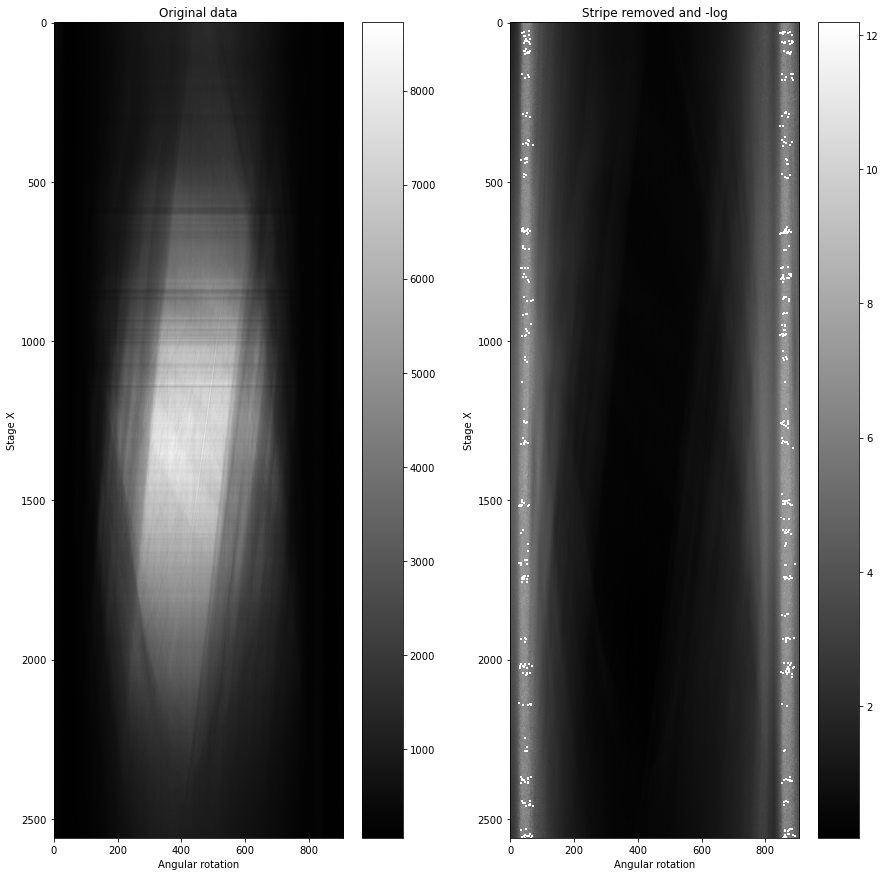

In [15]:
print(tomodata.shape)
fig, axs = plt.subplots(1,2,figsize=(15, 15))
#recon = tomopy.circ_mask(recon, axis=0, ratio=0.9)
img_plot_orig = axs[0].imshow(tomodata[:,1,:].T, cmap = 'gray')
axs[0].set_title('Original data')
axs[0].set_xlabel("Angular rotation")
axs[0].set_ylabel("Stage X")
plt.colorbar(img_plot_orig, ax=axs[0], orientation='vertical')

img_plot_mlog = axs[1].imshow(proj[:,1,:].T, cmap = 'gray')
axs[1].set_title('Stripe removed and -log')
axs[1].set_xlabel("Angular rotation")
axs[1].set_ylabel("Stage X")
plt.colorbar(img_plot_mlog, ax=axs[1], orientation='vertical')
#img_plot.set_clim(0.0, 0.01)


### Take a look at the angles collected
The best results come from a full 360$^\circ$ rotation because you get redundant data the can help with denoising. In this case we have 200$^\circ$ of angular data. The missing wedge problem comes from reconstructing data from angular data less than 180$^\circ$. 

In [16]:
angle_data = file["angle"]
print('First angle logged: ' + str(angle_data[0]))
print('Last angle logged: ' + str(angle_data[-1]))

First angle logged: 0.5305247546881297
Last angle logged: 199.98801037835477


In [17]:
# Manual selection of wedge
print(angle_data[180])
print(angle_data[800])

40.126221229393266
176.5218793492611


### Find center (coarse)

Make new folder in directory manually. View results with ImageJ/Fiji.



In [19]:
num_slices = 3 #reconstuct 3 slices

time_start = time.time()

# manually define angles, this has missing wedge
theta = np.linspace(0,2*np.pi*136/360,800-180)
proj_180  = proj[180:800,:,:]

for center in np.linspace(800,1800,100):
    recon = tomopy.recon(proj_180[:,:num_slices,:],theta,center=center,algorithm='gridrec')
    im = Image.fromarray(recon[2,:,:])
    im.save("test_center/test_center" + "{0:.2f}".format(center) + ".tif")

time_end  = time.time()
print(' *** recon done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')

 *** recon done in 0.9 minutes


### Find center (fine)
Determine new range based on prior output

In [24]:
for center in np.linspace(1200,1300,200):
    recon = tomopy.recon(proj_180[:,:num_slices,:],theta,center=center,algorithm='gridrec',filter_name='parzen')
    im = Image.fromarray(recon[1,:,:])
    im.save("test_center_fine/test_center_fine" + "{0:.2f}".format(center) + ".tif")

### Example reconstruction - gridrec

Using gridrec (fourier method) for quick reconstruction  
We can explore other methods/filter to get better results

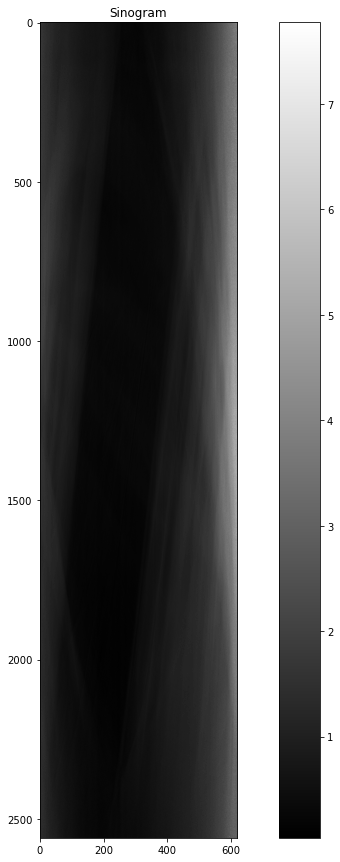

In [25]:
fig, axs = plt.subplots(figsize=(15, 15))

img_plot_mlog = plt.imshow(proj_180[:,3,:].T, cmap = 'gray')
plt.title('Sinogram')
plt.colorbar(img_plot_mlog, orientation='vertical')

In [27]:
time_start = time.time()

center = 1245

recon_slices = tomopy.recon(proj_180[:,:,:],theta,center=center,algorithm='gridrec',filter_name='parzen')
for n in range(1,5):
    im = Image.fromarray(recon_slices[n,:,:])
    im.save("recon_output/slice_" + str(n).zfill(4) + ".tif")
    
time_end  = time.time()
print(' *** recon done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')

 *** recon done in 0.01 minutes


(5, 2560, 2560)


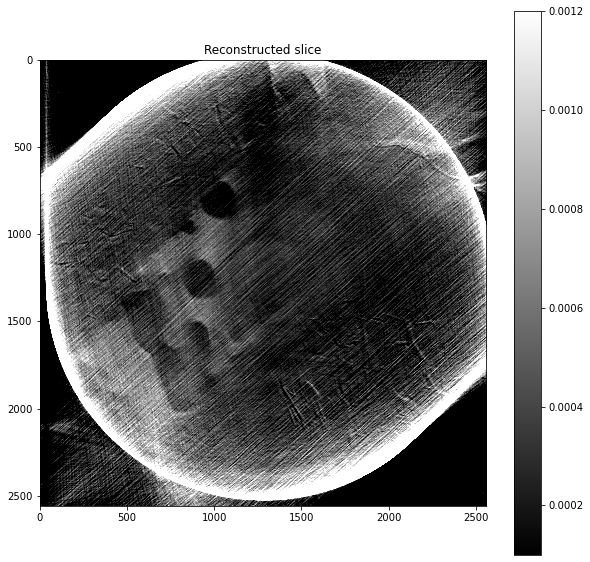

In [34]:
print(recon_slices.shape)
fig, ax = plt.subplots(figsize=(10, 10))
#recon = tomopy.circ_mask(recon, axis=0, ratio=0.9)
img_plot = plt.imshow(recon_slices[1,:,:], cmap = 'gray')
img_plot.set_clim(0.0001, 0.0012)
plt.title('Reconstructed slice')
plt.colorbar(orientation='vertical')

## Reconstruct entire dataset

In [ ]:
center = 1245

chunk_size = 50

time_start = time.time()

for c in range(0,2160,chunk_size):
    chunk_start = c
    chunk_end = chunk_start+chunk_size
    print('   From: ' + str(chunk_start) + ' to ' + str(chunk_end))
    
    tomodata = file["img_tomo"][:,chunk_start:chunk_end,:]
    #theta = np.linspace(0,2*np.pi,tomodata.shape[0])

    white =  file["img_bkg"][:,chunk_start:chunk_end,:]
    dark =  file["img_dark"][:,chunk_start:chunk_end,:]

    time_start = time.time()

    #print(' *** Normalizing')
    proj = tomopy.normalize(tomodata, white, dark)

    #print(' *** Remove Stripes')
    proj = tomopy.prep.stripe.remove_all_stripe(proj)
    
    # remove negative numbers
    proj = tomopy.misc.corr.remove_neg(proj, val=1e-3)

    #print(' *** - log')
    proj = tomopy.minus_log(proj)

    #print(' *** prep done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')
    theta = np.linspace(0,2*np.pi*136/360,800-180)
    proj_180  = proj[180:800,:,:]
    
    recon_slices = tomopy.recon(proj_180,theta,center=center,algorithm='gridrec',filter_name='parzen', ncore=8)
    
    for n in range(0,chunk_size):
        im = Image.fromarray(recon_slices[n,:,:])
        im.save("recon_gridrec_parzen_output/slice_" + str(chunk_start+n).zfill(4) + ".tif")

time_end  = time.time()
print(' *** Recon time: ' + str(round((time_end-time_start)/60,2)) + ' minutes')


   From: 0 to 50
   From: 50 to 100
   From: 100 to 150
   From: 150 to 200
   From: 200 to 250
   From: 250 to 300
   From: 300 to 350
   From: 350 to 400
   From: 400 to 450
   From: 450 to 500
   From: 500 to 550
   From: 550 to 600
   From: 600 to 650
   From: 650 to 700
   From: 700 to 750
   From: 750 to 800


## Summary

This notebook details the basic procedure to go about reconstructing the TXM tomography data collected. Note the phase contrast comes from attenuation. In this case, Al is less dense than Al<sub>2</sub>Cu. The forward transmitted x-rays are attenuated less when they pass through the Al phase. So on the imaging detector, the brighter phase (corresponding higher signal) is Al. When we take the negative log to back out the attenuation via the Beer-Lambert Law, the Al is the dark phase in these -log(projections). We use the -log(projections) in the reconstruction so the dark phase in the reconstruction is the Al phase.

Things to work on: 
- Implementing missing wedge codes. 
- Using other reconstruction filters and algorithms.
- I think Total Variation (TV) is a promising interative reconstruction algorithm to look into.
- Maybe more comments and a better guide